# Clasificador de Lenguaje de Señas: Primera aproximación

La idea del proyecto es hacer un clasificador que pueda distinguir distintas letras del alfabeto del lenguaje de señas mexicano. Al ser una primera aproximación, sólamente buscaremos clasificar una cantidad limitada de letras estáticas.

Para la obtención de características nos apoyaremos del framework **mediapipe**, de Google, el cual obtiene 21 puntos característicos de la mano. Una vez obtenidos los puntos, obtendremos algunas medidas que nos permitirán diferenciar entre cada seña (_feature vector_).

In [1]:
import mediapipe as mp
import cv2
import numpy as np
import os

In [2]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

## Obtención de los puntos de la mano

El framework **mediapipe** ya realiza todo el trabajo, prácticamente. Simplemente leemos la imagen y regresamos los puntos de la manera en que queremos manipularlos.

In [3]:
def getHandLandmarks(image_path: str) -> list:
    with mp_hands.Hands(
        static_image_mode = True,
        max_num_hands=2,
        min_detection_confidence=0.5
    ) as hands:
        image = cv2.flip(cv2.imread(image_path),1)
        results = hands.process(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
        
        if results.multi_hand_landmarks:
            return results.multi_hand_landmarks[0].landmark
    

In [4]:
# Calcula el ángulo entre 3 puntos.
# Regresa el valor en radianes
def getAngleBetweenLandmarks(l1,l2,l3):
    vect1 = np.array([l1.x - l2.x, l1.y - l2.y, l1.z - l2.z])
    vect2 = np.array([l3.x - l2.x, l3.y - l3.y, l3.z - l2.z])
    
    
    cos = (np.dot(vect1,vect2) / (np.linalg.norm(vect1) * np.linalg.norm(vect2)))
    
    return np.arccos(cos)
    

In [5]:
hand1 = getHandLandmarks('mano1.jpg')


In [6]:
print(hand1[4],hand1[0],hand1[5])
angle = getAngleBetweenLandmarks(hand1[4],hand1[0],hand1[5])
print(angle)
print((angle * 180) / np.pi)

x: 0.6187741756439209
y: 0.23841719329357147
z: -0.14854207634925842
 x: 0.6896867752075195
y: 0.6558972001075745
z: 1.2657428669626825e-06
 x: 0.5103555917739868
y: 0.4604223370552063
z: -0.1172165498137474

1.2520510258096818
71.73723951392007


# ¿Qué ángulos usaremos para la clasificación?

<img src="https://mediapipe.dev/images/mobile/hand_landmarks.png" width="50%">


### Apertura entre dedos
* 4 - 0 - 5
* 8 - 0 - 12
* 12 - 0 - 16
* 16 - 0 - 20

### Dobleces de falanges
* 4 - 3 - 2
* 8 - 7 - 6
* 12 - 11 - 10
* 16 - 15 - 14
* 20 - 19 - 18

### Dobleces de dedos

* 4 - 2 - 0
* 8 - 5 - 0
* 12 - 9 - 0
* 16 - 13 - 0
* 20 - 17 - 0

La pregunta es, ¿son suficientes estos ángulos para la representación?, ¿agregaremos más?, ¿quitaremos algunos?




In [7]:
def getImportantAngles(hand):
    
    angles = []
    
    landmarks = [
        # Apertura entre dedos
        [4,0,5],
        [8,0,12],
        [12,0,16],
        [16,0,20],
        # Dobleces de falanges
        [4,3,2],
        [8,7,6],
        [12,11,10],
        [16,15,14],
        [20,19,18],
        # Dobleces de dedos
        [4,2,0],
        [8,5,0],
        [12,9,0],
        [16,13,0],
        [20,17,0]
    ]
    
    for lm in landmarks:
        angle = getAngleBetweenLandmarks(hand[lm[0]], hand[lm[1]], hand[lm[2]])
        angles.append(angle)
    
    return np.array(angles)
    

In [8]:
v1 = getImportantAngles(hand1)
print(v1)

[1.25205103 0.70637281 0.49389556 0.26417434 1.85140494 2.55201243
 2.71335022 2.79935001 2.84527729 1.93737934 2.44269359 2.60112031
 2.79439416 2.92207401]


## ¿Qué señas vamos a probar?

Para empezar, debemos elegir una serie de señas para evaluar un posible clasificador.

<img src="https://img.freepik.com/vector-gratis/alfabeto-lenguaje-signos_23-2147896970.jpg" width="400px">

Como primera prueba, podemos elegir señas muy diferentes entre sí. Como segunda prueba, elegir señas similares para medir la precisión de nuestra propuesta.

### Prueba 1:

Señas diferentes entre sí:

* A
* C
* H
* I
* S
* L

### Prueba 2:

Señas similares entre sí:

* C
* O
* S
* T
* U
* H

In [9]:
def getTrainingDataFromPath(dataset_path: str, label: str) -> list:
    data = []
    
    for img in os.listdir(dataset_path):
        hand = getHandLandmarks(dataset_path+'/'+img)
        if hand:
            data.append(getImportantAngles(hand))
    
    return data, [label for _ in range(len(data))]

## Prueba 1
### Clasificador Gaussiano

Aplicación de un clasificador simple Gaussiano.

In [10]:
def getTrainingData(test: list):
    TRAINING_PATH = './asl_alphabet_train/asl_alphabet_train/'
    
    training_data = []
    training_lbls = []

    for letter in test:
        data, label = getTrainingDataFromPath(TRAINING_PATH+letter,letter)
        training_data += data
        training_lbls += label
    
    return training_data, training_lbls

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

TEST_ONE = ['A','C','H','I','S','L']
test_one_data, test_one_labels = getTrainingData(TEST_ONE)

In [12]:
test_one_x_train, test_one_x_test, test_one_y_train, test_one_y_test = train_test_split(test_one_data, test_one_labels, test_size=0.3, random_state=21)

In [13]:
test_one_gnb = GaussianNB()
test_one_gnb.fit(test_one_x_train, test_one_y_train)

GaussianNB()

In [14]:
test_one_y_pred = test_one_gnb.predict(test_one_x_test)
test_one_accuracy = accuracy_score(test_one_y_test, test_one_y_pred)
print(test_one_accuracy)

0.9729344729344729


Text(113.9222222222222, 0.5, 'Pred label')

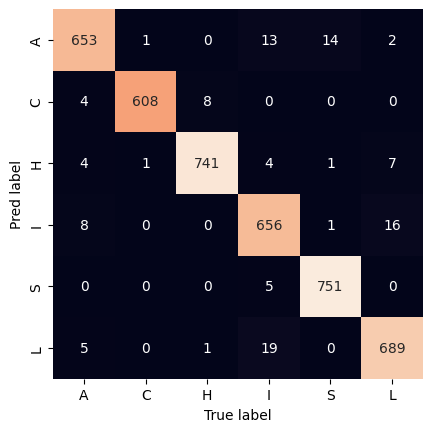

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

mat = confusion_matrix(test_one_y_test, test_one_y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=TEST_ONE,
            yticklabels=TEST_ONE)

plt.xlabel('True label')
plt.ylabel('Pred label')

### Implementando k-means

Implementamos el algoritmo de aprendizaje no supervisado. Nuestra hipótesis es que, con los datos obtenidos y las diferencias entre distintas señas debería proveer una buena fuente de entrenamiento para un algoritmo no supervisado, separando las señas similares entre sí.

In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, LabelEncoder


In [17]:
# Estandarizamos los datos para que tengan media 0 y dev_std 1
scaler = StandardScaler()
scaled_data = scaler.fit_transform(test_one_data)

In [103]:
kmeans = KMeans(
  init="k-means++",
  n_clusters=6,
  n_init=10,
  max_iter=300,
  random_state=21
)

In [104]:
kmeans.fit(scaled_data)

KMeans(n_clusters=6, random_state=21)

In [285]:
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(test_one_labels)

In [21]:
from sklearn.metrics import adjusted_rand_score

ari_kmeans = adjusted_rand_score(test_one_labels,kmeans.labels_)


print(round(ari_kmeans,2))


0.85


### Construyendo un Pipeline

In [85]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(test_one_labels)

preprocessor = Pipeline(
  [
    ("scaler",StandardScaler()),
    ("pca",PCA(n_components=2,random_state=21))
  ]
)

clusterer = Pipeline(
  [
    ("kmeans",KMeans(
        n_clusters=6,
        init="k-means++",
        n_init=10,
        max_iter=300,
        random_state=21
      )
    )
  ]
)

pipe = Pipeline(
  [
    ("preprocessor", preprocessor),
    ("clusterer",clusterer)
  ]
)


In [23]:
pipe.fit(test_one_data)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', StandardScaler()),
                                 ('pca',
                                  PCA(n_components=2, random_state=21))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(n_clusters=6, random_state=21))]))])

In [24]:
preprocessed_data = pipe["preprocessor"].transform(test_one_data)

predicted_labels  = pipe["clusterer"]["kmeans"].labels_

slt = silhouette_score(preprocessed_data, predicted_labels) 
print(slt)

0.5170192575854442


In [25]:
scr = adjusted_rand_score(true_labels, predicted_labels)
print(scr)

0.6619140304692592


### Medición de desempeño de Kmeans

Primero, medimos el desempeño de acuerdo al número de componentes en PCA

In [26]:
silhouette_scores = []
ari_scores = []

for i in range(2,15):
    pipe["preprocessor"]["pca"].n_components = i
    pipe.fit(test_one_data)
    
    silhouette_coef = silhouette_score(
        pipe["preprocessor"].transform(test_one_data),
        pipe["clusterer"]["kmeans"].labels_
    )
    
    ari = adjusted_rand_score(
        true_labels,
        pipe["clusterer"]["kmeans"].labels_
    )
    
    silhouette_scores.append(silhouette_coef)
    ari_scores.append(ari)

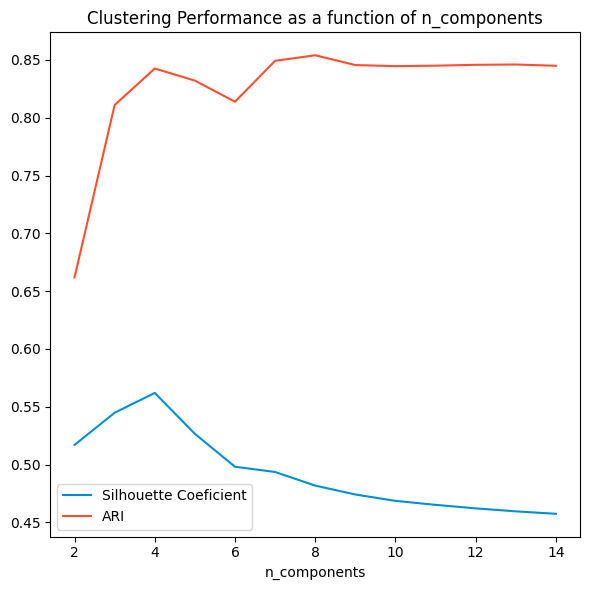

In [27]:
plt.figure(figsize=(6,6))
plt.plot(
  [i for i in range(2,15)],
  silhouette_scores,
  label="Silhouette Coeficient",
  c="#008fd5"
)
plt.plot(
  [i for i in range(2,15)],
  ari_scores,
  label="ARI",
  c="#fc4f30"
)
plt.xlabel("n_components")
plt.legend()
plt.title("Clustering Performance as a function of n_components")
plt.tight_layout()
plt.show()

In [86]:
pipe["preprocessor"]["pca"].n_components = 8
pipe.fit(test_one_data)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', StandardScaler()),
                                 ('pca',
                                  PCA(n_components=8, random_state=21))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(n_clusters=6, random_state=21))]))])

In [29]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_mutual_info_score

# Mide la coincidencia entre ambas asignaciones sin contar permutaciones
nmi = normalized_mutual_info_score(true_labels, pipe["clusterer"]["kmeans"].labels_)
ami = adjusted_mutual_info_score(true_labels, pipe["clusterer"]["kmeans"].labels_)

# Más cercano a 1 mejor

print("Normalized Mutual Information: ",nmi)
print("Adjusted Mutual Information: ",ami)

Normalized Mutual Information:  0.851591362076273
Adjusted Mutual Information:  0.8515173863927716


In [30]:
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score

homogeneity  = homogeneity_score(true_labels, pipe["clusterer"]["kmeans"].labels_)
completeness = completeness_score(true_labels, pipe["clusterer"]["kmeans"].labels_)
v_measure    = v_measure_score(true_labels, pipe["clusterer"]["kmeans"].labels_)

print("Homogeneity: ", homogeneity)
print("Completeness: {}".format(completeness)) 
print("V-measure: ",v_measure)

Homogeneity:  0.8515726498420396
Completeness: 0.8516100751328798
V-measure:  0.851591362076273


In [31]:
from sklearn.metrics import fowlkes_mallows_score

fms = fowlkes_mallows_score(true_labels, pipe["clusterer"]["kmeans"].labels_)

print("Fowlkes-Mallows score: {}".format(fms))

Fowlkes-Mallows score: 0.8784892351987511


In [95]:
homogeneity_scores = []
completeness_scores = []
v_masure_scores = []
nmi_scores = []
ami_scores = []
fms_scores = []

for i in range(2,15):
    pipe["preprocessor"]["pca"].n_components = i
    pipe.fit(test_one_data)
    
    nmi = normalized_mutual_info_score(true_labels, pipe["clusterer"]["kmeans"].labels_)
    ami = adjusted_mutual_info_score(true_labels, pipe["clusterer"]["kmeans"].labels_)
    homogeneity  = homogeneity_score(true_labels, pipe["clusterer"]["kmeans"].labels_)
    completeness = completeness_score(true_labels, pipe["clusterer"]["kmeans"].labels_)
    v_measure    = v_measure_score(true_labels, pipe["clusterer"]["kmeans"].labels_)
    fms = fowlkes_mallows_score(true_labels, pipe["clusterer"]["kmeans"].labels_)
    
    homogeneity_scores.append(homogeneity)
    completeness_scores.append(completeness)
    v_masure_scores.append(v_measure)
    nmi_scores.append(nmi)
    ami_scores.append(ami)
    fms_scores.append(fms)
    
    

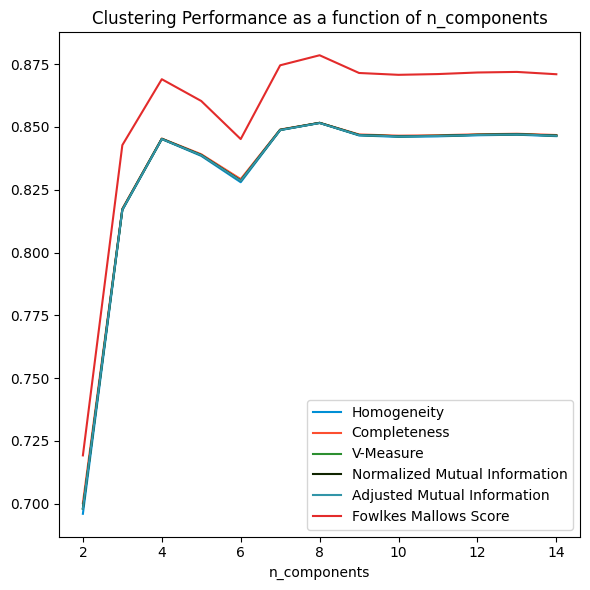

In [96]:
plt.figure(figsize=(6,6))
plt.plot(
  [i for i in range(2,15)],
  homogeneity_scores,
  label="Homogeneity",
  c="#008fd5"
)
plt.plot(
  [i for i in range(2,15)],
  completeness_scores,
  label="Completeness",
  c="#fc4f30"
)
plt.plot(
  [i for i in range(2,15)],
  v_masure_scores,
  label="V-Measure",
  c="#2c8f30"
)
plt.plot(
  [i for i in range(2,15)],
  nmi_scores,
  label="Normalized Mutual Information",
  c="#102400"
)
plt.plot(
  [i for i in range(2,15)],
  ami_scores,
  label="Adjusted Mutual Information",
  c="#3295a8"
)
plt.plot(
  [i for i in range(2,15)],
  fms_scores,
  label="Fowlkes Mallows Score",
  c="#e32b2b"
)
plt.xlabel("n_components")
plt.legend()
plt.title("Clustering Performance as a function of n_components")
plt.tight_layout()
plt.show()

0.9293447293447293


Text(113.9222222222222, 0.5, 'Pred label')

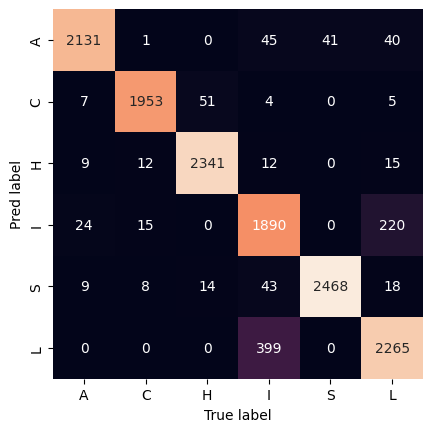

In [156]:
pipe["preprocessor"]["pca"].n_components = 14
pipe.fit(test_one_data)
print(accuracy_score(true_labels, pipe["clusterer"]["kmeans"].labels_))
mat = confusion_matrix(true_labels, pipe["clusterer"]["kmeans"].labels_)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=TEST_ONE,
            yticklabels=TEST_ONE)

plt.xlabel('True label')
plt.ylabel('Pred label')

14
0.9293447293447293


Text(113.9222222222222, 0.5, 'Pred label')

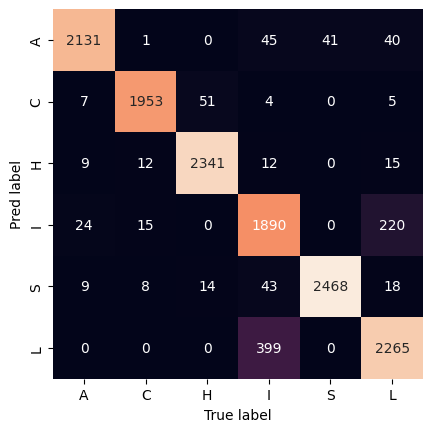

In [141]:
print(len(test_one_data[0]))
print(accuracy_score(true_labels, kmeans.labels_))
mat = confusion_matrix(true_labels, kmeans.labels_)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=TEST_ONE,
            yticklabels=TEST_ONE)

plt.xlabel('True label')
plt.ylabel('Pred label')


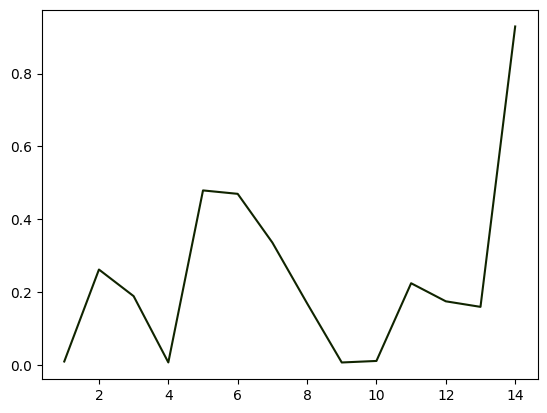

In [144]:
accuracy_scores_t1 = []

for i in range(1,15):
  pipe["preprocessor"]["pca"].n_components = i
  pipe.fit(test_one_data)
  accuracy_scores_t1.append(accuracy_score(true_labels, pipe["clusterer"]["kmeans"].labels_))
  
plt.plot(
  [i for i in range(1,15)],
  accuracy_scores_t1,
  label="Accuracy Score",
  c="#102400"
)

In [155]:
from sklearn.metrics import precision_score

precision_score(true_labels, kmeans.labels_, average=None)

array([0.94375554, 0.96683168, 0.97990791, 0.87947883, 0.9640625 ,
       0.85022523])

### Implementando DBSCAN

In [34]:
from sklearn.cluster import DBSCAN

dbscan_cluster = DBSCAN()

x = dbscan_cluster.fit_predict(test_one_data)

In [35]:
adjusted_mutual_info_score(true_labels,x)

0.7620724307788472

In [36]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=2)
vecinos = neigh.fit(test_one_data)
distances, indices = vecinos.kneighbors(test_one_data)

Text(0, 0.5, 'Distance')

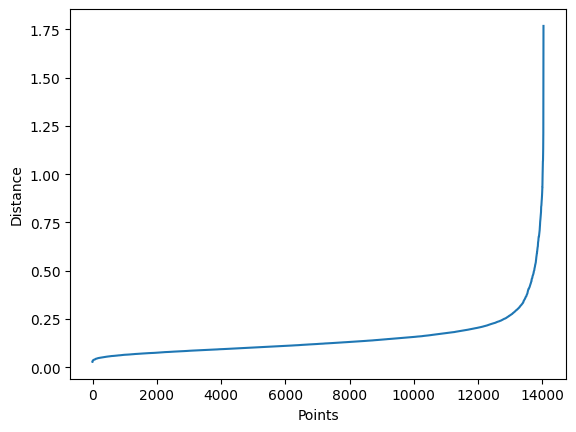

In [37]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")

In [38]:
dbscan_cluster = DBSCAN(eps=0.25)

dbscan_result = dbscan_cluster.fit_predict(test_one_data)

In [39]:

nmi_dbscan = normalized_mutual_info_score(
    true_labels, dbscan_result)
ami_dbscan = adjusted_mutual_info_score(
    true_labels, dbscan_result)
homogeneity_dbscan = homogeneity_score(
    true_labels, dbscan_result)
completeness_dbscan = completeness_score(
    true_labels, dbscan_result)
v_measure_dbscan = v_measure_score(
    true_labels, dbscan_result)
fms_dbscan = fowlkes_mallows_score(
    true_labels, dbscan_result)

print("Normalized Mutual Information: ",nmi_dbscan)
print("Adjusted Mutual Information: ",ami_dbscan)
print("Homogeneity: ",homogeneity_dbscan)
print("Completeness: ",completeness_dbscan)
print("V-Measure: ",v_measure_dbscan)
print("Fowlkes Mallows Score: ",fms_dbscan)

Normalized Mutual Information:  0.8249819283539173
Adjusted Mutual Information:  0.8243558846007681
Homogeneity:  0.8909764225938427
Completeness:  0.7680896402382771
V-Measure:  0.8249819283539174
Fowlkes Mallows Score:  0.8299611324277998


In [394]:
preprocessor_dbscan = Pipeline(
  [
    # ("scaler",StandardScaler()),
    ("pca",PCA(n_components=2,random_state=21))
  ]
)

clusterer_dbscan = Pipeline(
  [
    ("dbscan",DBSCAN(eps=0.2,min_samples=35))
  ]
)

pipe_dbscan = Pipeline(
  [
    ("preprocessor", preprocessor_dbscan),
    ("clusterer",clusterer_dbscan)
  ]
)

In [363]:
homogeneity_scores = []
completeness_scores = []
v_masure_scores = []
nmi_scores = []
ami_scores = []
fms_scores = []

for i in range(2,15):
    pipe_dbscan["preprocessor"]["pca"].n_components = i
    pipe_dbscan.fit(test_one_data)
    
    nmi = normalized_mutual_info_score(true_labels, pipe_dbscan["clusterer"]["dbscan"].labels_)
    ami = adjusted_mutual_info_score(true_labels, pipe_dbscan["clusterer"]["dbscan"].labels_)
    homogeneity  = homogeneity_score(true_labels, pipe_dbscan["clusterer"]["dbscan"].labels_)
    completeness = completeness_score(true_labels, pipe_dbscan["clusterer"]["dbscan"].labels_)
    v_measure    = v_measure_score(true_labels, pipe_dbscan["clusterer"]["dbscan"].labels_)
    fms = fowlkes_mallows_score(true_labels, pipe_dbscan["clusterer"]["dbscan"].labels_)
    
    homogeneity_scores.append(homogeneity)
    completeness_scores.append(completeness)
    v_masure_scores.append(v_measure)
    nmi_scores.append(nmi)
    ami_scores.append(ami)
    fms_scores.append(fms)

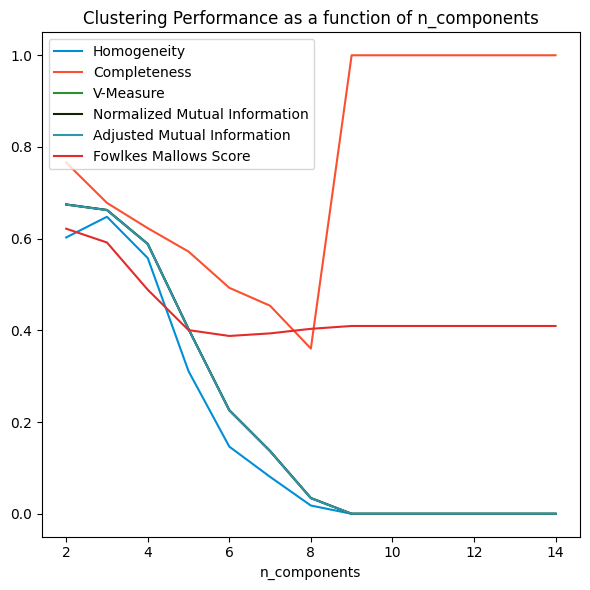

In [364]:
plt.figure(figsize=(6,6))
plt.plot(
  [i for i in range(2,15)],
  homogeneity_scores,
  label="Homogeneity",
  c="#008fd5"
)
plt.plot(
  [i for i in range(2,15)],
  completeness_scores,
  label="Completeness",
  c="#fc4f30"
)
plt.plot(
  [i for i in range(2,15)],
  v_masure_scores,
  label="V-Measure",
  c="#2c8f30"
)
plt.plot(
  [i for i in range(2,15)],
  nmi_scores,
  label="Normalized Mutual Information",
  c="#102400"
)
plt.plot(
  [i for i in range(2,15)],
  ami_scores,
  label="Adjusted Mutual Information",
  c="#3295a8"
)
plt.plot(
  [i for i in range(2,15)],
  fms_scores,
  label="Fowlkes Mallows Score",
  c="#e32b2b"
)
plt.xlabel("n_components")
plt.legend()
plt.title("Clustering Performance as a function of n_components")
plt.tight_layout()
plt.show()

In [376]:
pipe_dbscan["preprocessor"]["pca"].n_components = 5
pipe_dbscan.fit(test_one_data)
np.unique(pipe_dbscan["clusterer"]["dbscan"].labels_)

array([-1,  0,  1,  2,  3,  4], dtype=int64)

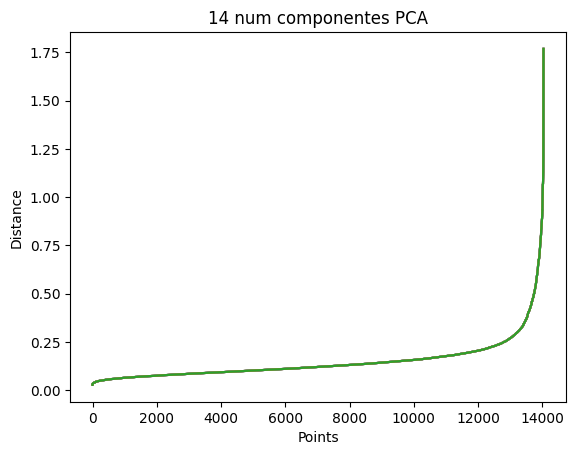

In [43]:
neigh = NearestNeighbors(n_neighbors=2)

for i in range(2,15):
  pipe_dbscan["preprocessor"]["pca"].n_components = i
  trans_data = pipe_dbscan["preprocessor"].transform(test_one_data)
  vecinos = neigh.fit(test_one_data)
  distances, indices = vecinos.kneighbors(test_one_data)
  distances = np.sort(distances, axis=0)
  distances = distances[:,1]
  plt.plot(distances)
  plt.title("{} num componentes PCA".format(i))
  plt.xlabel("Points")
  plt.ylabel("Distance")
  plt.savefig("./knn_dbscan/{}_num_components.png".format(i))
  
  

Text(113.9222222222222, 0.5, 'Pred label')

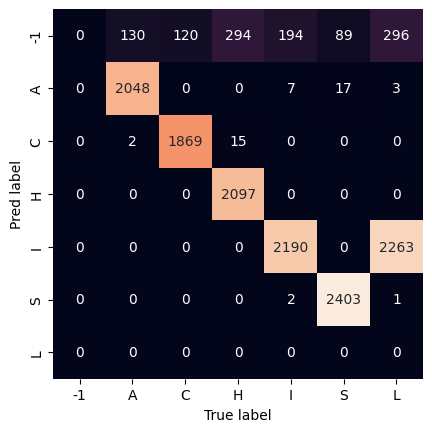

In [400]:
pipe_dbscan["preprocessor"]["pca"].n_components = 4
pipe_dbscan.fit(test_one_data)
mat = confusion_matrix(true_labels, pipe_dbscan["clusterer"]["dbscan"].labels_)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=[-1]+TEST_ONE,
            yticklabels=[-1]+TEST_ONE)

plt.xlabel('True label')
plt.ylabel('Pred label')

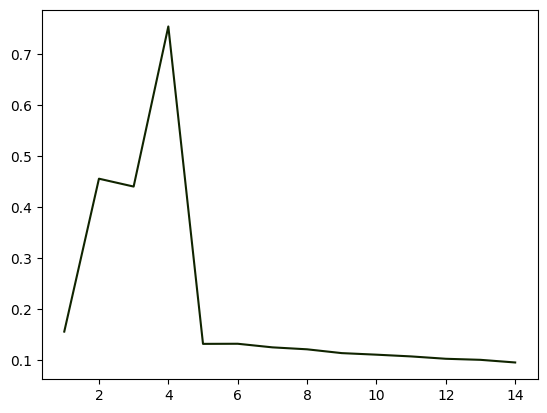

In [401]:
accuracy_dbscan= []
pipe_dbscan["clusterer"]["dbscan"].min_samples = 29

for i in range(1,15):
  pipe_dbscan["preprocessor"]["pca"].n_components = i
  pipe_dbscan.fit(test_one_data)
  accuracy_dbscan.append(accuracy_score(true_labels, pipe_dbscan["clusterer"]["dbscan"].labels_))
  
plt.plot(
  [i for i in range(1,15)],
  accuracy_dbscan,
  label="Accuracy Score",
  c="#102400"
)

In [398]:
max_acc = dict()
for mn in range (10,51,2):
  pipe_dbscan["clusterer"]["dbscan"].min_samples = mn
  accuracy_dbscan1= []

  for i in range(1,15):
    pipe_dbscan["preprocessor"]["pca"].n_components = i
    pipe_dbscan.fit(test_one_data)
    accuracy_dbscan1.append(accuracy_score(true_labels, pipe_dbscan["clusterer"]["dbscan"].labels_))
  
  max_acc[str(mn)] = max(accuracy_dbscan1)

print(max_acc)

{'10': 0.45904558404558404, '12': 0.6091880341880341, '14': 0.45883190883190883, '16': 0.4585470085470085, '18': 0.31987179487179485, '20': 0.4947293447293447, '22': 0.4940883190883191, '24': 0.4935897435897436, '26': 0.4933760683760684, '28': 0.7554843304843305, '30': 0.7533475783475784, '32': 0.4551282051282051, '34': 0.4548433048433048, '36': 0.45427350427350427, '38': 0.4542022792022792, '40': 0.4542022792022792, '42': 0.4537037037037037, '44': 0.4532763532763533, '46': 0.4530626780626781, '48': 0.4530626780626781, '50': 0.4527065527065527}


# Prueba 2

Señas similares entre sí:

* C
* O
* S
* T
* U
* H

In [44]:
test_two_letters = ['C','O','S','T','U','H']
test_two_data = getTrainingData(test_two_letters)

### Clasificador Gaussiano

In [45]:
# Clasificador Gaussiano

test_two_x, test_two_y = test_two_data

t2_x_train, t2_x_test, t2_y_train, t2_y_test = train_test_split(test_two_x, test_two_y, test_size=0.3, random_state=21)

t2_gnb = GaussianNB()
t2_gnb.fit(t2_x_train,t2_y_train)

t2_y_predict = t2_gnb.predict(t2_x_test)
t2_accuracy  = accuracy_score(t2_y_test,t2_y_predict)

print("Accuracy score GNB: ",t2_accuracy) 

Accuracy score GNB:  0.982717803030303


Text(113.9222222222222, 0.5, 'Pred label')

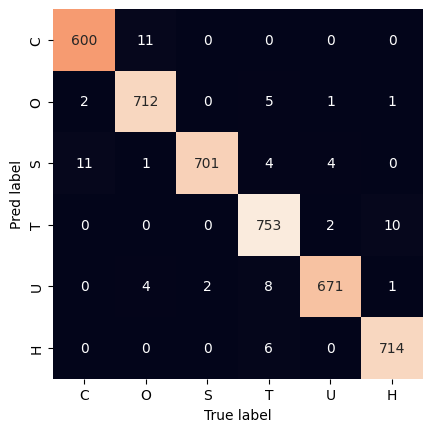

In [46]:
mat = confusion_matrix(t2_y_test, t2_y_predict)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=test_two_letters,
            yticklabels=test_two_letters)

plt.xlabel('True label')
plt.ylabel('Pred label')

### K-means

In [159]:
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(test_two_y)

t2_preprocessor = Pipeline(
  [
    ("scaler",StandardScaler()),
    ("pca",PCA(n_components=6,random_state=21))
  ]
)

t2_clusterer = Pipeline(
  [
    ("kmeans",KMeans(
        n_clusters=6,
        init="k-means++",
        n_init=10,
        max_iter=300,
        random_state=21
      )
    )
  ]
)

t2_pipe = Pipeline(
  [
    ("preprocessor", t2_preprocessor),
    ("clusterer",t2_clusterer)
  ]
)

t2_pipe.fit(test_two_x)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', StandardScaler()),
                                 ('pca',
                                  PCA(n_components=6, random_state=21))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(n_clusters=6, random_state=21))]))])

In [48]:
silhouette_scores = []
ari_scores = []
homogeneity_scores = []
completeness_scores = []
v_masure_scores = []
nmi_scores = []
ami_scores = []
fms_scores = []

for i in range(2,15):
    t2_pipe["preprocessor"]["pca"].n_components = i
    t2_pipe.fit(test_two_x)
    
    silhouette_coef = silhouette_score(t2_pipe["preprocessor"].transform(test_two_x),t2_pipe["clusterer"]["kmeans"].labels_)
    ari = adjusted_rand_score(true_labels,t2_pipe["clusterer"]["kmeans"].labels_)
    nmi = normalized_mutual_info_score(true_labels, t2_pipe["clusterer"]["kmeans"].labels_)
    ami = adjusted_mutual_info_score(true_labels, t2_pipe["clusterer"]["kmeans"].labels_)
    homogeneity  = homogeneity_score(true_labels, t2_pipe["clusterer"]["kmeans"].labels_)
    completeness = completeness_score(true_labels, t2_pipe["clusterer"]["kmeans"].labels_)
    v_measure    = v_measure_score(true_labels, t2_pipe["clusterer"]["kmeans"].labels_)
    fms = fowlkes_mallows_score(true_labels, t2_pipe["clusterer"]["kmeans"].labels_)
    
    silhouette_scores.append(silhouette_coef)
    ari_scores.append(ari)
    homogeneity_scores.append(homogeneity)
    completeness_scores.append(completeness)
    v_masure_scores.append(v_measure)
    nmi_scores.append(nmi)
    ami_scores.append(ami)
    fms_scores.append(fms)

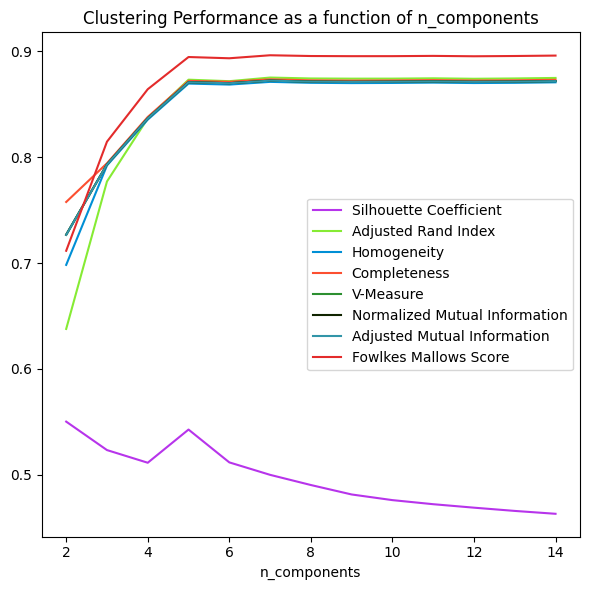

In [49]:
plt.figure(figsize=(6,6))
plt.plot(
  [i for i in range(2,15)],
  silhouette_scores,
  label="Silhouette Coefficient",
  c="#b734eb"
)
plt.plot(
  [i for i in range(2,15)],
  ari_scores,
  label="Adjusted Rand Index",
  c="#86eb34"
)
plt.plot(
  [i for i in range(2,15)],
  homogeneity_scores,
  label="Homogeneity",
  c="#008fd5"
)
plt.plot(
  [i for i in range(2,15)],
  completeness_scores,
  label="Completeness",
  c="#fc4f30"
)
plt.plot(
  [i for i in range(2,15)],
  v_masure_scores,
  label="V-Measure",
  c="#2c8f30"
)
plt.plot(
  [i for i in range(2,15)],
  nmi_scores,
  label="Normalized Mutual Information",
  c="#102400"
)
plt.plot(
  [i for i in range(2,15)],
  ami_scores,
  label="Adjusted Mutual Information",
  c="#3295a8"
)
plt.plot(
  [i for i in range(2,15)],
  fms_scores,
  label="Fowlkes Mallows Score",
  c="#e32b2b"
)
plt.xlabel("n_components")
plt.legend()
plt.title("Clustering Performance as a function of n_components")
plt.tight_layout()
plt.show()

In [402]:
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(test_two_y)

t2_pipe["preprocessor"]["pca"].n_components = 7
t2_pipe.fit(test_two_x)

silhouette_coef = silhouette_score(t2_pipe["preprocessor"].transform(test_two_x),t2_pipe["clusterer"]["kmeans"].labels_)
ari = adjusted_rand_score(true_labels,t2_pipe["clusterer"]["kmeans"].labels_)
nmi = normalized_mutual_info_score(true_labels, t2_pipe["clusterer"]["kmeans"].labels_)
ami = adjusted_mutual_info_score(true_labels, t2_pipe["clusterer"]["kmeans"].labels_)
homogeneity  = homogeneity_score(true_labels, t2_pipe["clusterer"]["kmeans"].labels_)
completeness = completeness_score(true_labels, t2_pipe["clusterer"]["kmeans"].labels_)
v_measure    = v_measure_score(true_labels, t2_pipe["clusterer"]["kmeans"].labels_)
fms = fowlkes_mallows_score(true_labels, t2_pipe["clusterer"]["kmeans"].labels_)

print("Silhouette Coeficient: {}".format(silhouette_coef))
print("Adjusted Rand Index: {}".format(ari))
print("Normal Mutual Information: {}".format(nmi))
print("Adjusted Mutual Information {}".format(ami))
print("Homogeneity: {}".format(homogeneity))
print("Completeness: {}".format(completeness))
print("V-Measure: {}".format(v_measure))
print("Fowlkes-Mallows Score: {}".format(fms))

Silhouette Coeficient: 0.5000782819918507
Adjusted Rand Index: 0.8751158398664501
Normal Mutual Information: 0.8722349542858722
Adjusted Mutual Information 0.8721713759295701
Homogeneity: 0.8710465272182969
Completeness: 0.8734266286851552
V-Measure: 0.8722349542858722
Fowlkes-Mallows Score: 0.8961600399686358


0.6376873357482776


Text(113.9222222222222, 0.5, 'Pred label')

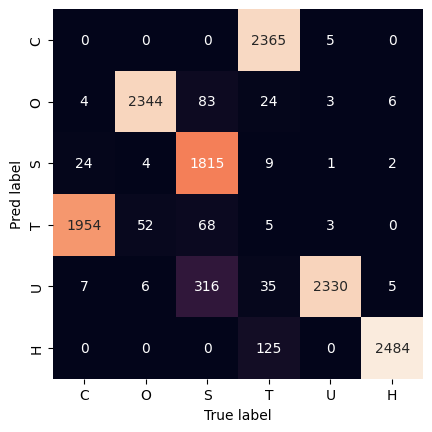

In [152]:
print(accuracy_score(true_labels,t2_pipe["clusterer"]["kmeans"].labels_))
mat = confusion_matrix(true_labels, t2_pipe["clusterer"]["kmeans"].labels_)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=test_two_letters,
            yticklabels=test_two_letters)

plt.xlabel('True label')
plt.ylabel('Pred label')

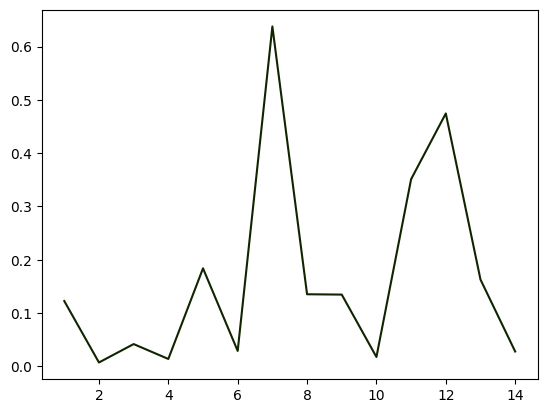

In [150]:
accuracy_scores_t2 = []

for i in range(1,15):
  t2_pipe["preprocessor"]["pca"].n_components = i
  t2_pipe.fit(test_two_x)
  accuracy_scores_t2.append(accuracy_score(true_labels, t2_pipe["clusterer"]["kmeans"].labels_))
  
plt.plot(
  [i for i in range(1,15)],
  accuracy_scores_t2,
  label="Accuracy Score",
  c="#102400"
)

### DBSCAN

Text(0, 0.5, 'Distance')

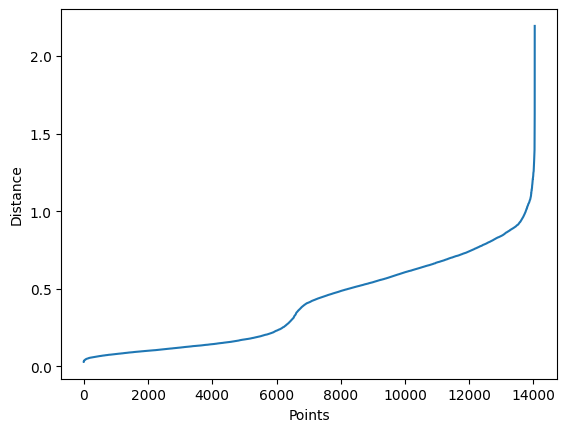

In [51]:
neigh = NearestNeighbors(n_neighbors=2)
vecinos = neigh.fit(test_two_x)
distances, indices = vecinos.kneighbors(test_one_data)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")

In [270]:
t2_preprocessor_dbscan = Pipeline(
  [
    # ("scaler",StandardScaler()),
    ("pca",PCA(n_components=2,random_state=21))
  ]
)

t2_clusterer_dbscan = Pipeline(
  [
    ("dbscan",DBSCAN(eps=0.8,min_samples=400))
  ]
)

t2_pipe_dbscan = Pipeline(
  [
    ("preprocessor", t2_preprocessor_dbscan),
    ("clusterer",t2_clusterer_dbscan)
  ]
)

In [271]:
homogeneity_scores = []
completeness_scores = []
v_masure_scores = []
nmi_scores = []
ami_scores = []
fms_scores = []
ari_scores = []

for i in range(2,15):
    t2_pipe_dbscan["preprocessor"]["pca"].n_components = i
    t2_pipe_dbscan.fit(test_two_x)
    
    nmi = normalized_mutual_info_score(true_labels, t2_pipe_dbscan["clusterer"]["dbscan"].labels_)
    ami = adjusted_mutual_info_score(true_labels, t2_pipe_dbscan["clusterer"]["dbscan"].labels_)
    homogeneity  = homogeneity_score(true_labels, t2_pipe_dbscan["clusterer"]["dbscan"].labels_)
    completeness = completeness_score(true_labels, t2_pipe_dbscan["clusterer"]["dbscan"].labels_)
    v_measure    = v_measure_score(true_labels, t2_pipe_dbscan["clusterer"]["dbscan"].labels_)
    fms = fowlkes_mallows_score(true_labels, t2_pipe_dbscan["clusterer"]["dbscan"].labels_)
    ari = adjusted_rand_score(true_labels, t2_pipe_dbscan["clusterer"]["dbscan"].labels_)
    
    homogeneity_scores.append(homogeneity)
    completeness_scores.append(completeness)
    v_masure_scores.append(v_measure)
    nmi_scores.append(nmi)
    ami_scores.append(ami)
    fms_scores.append(fms)
    ari_scores.append(ari)

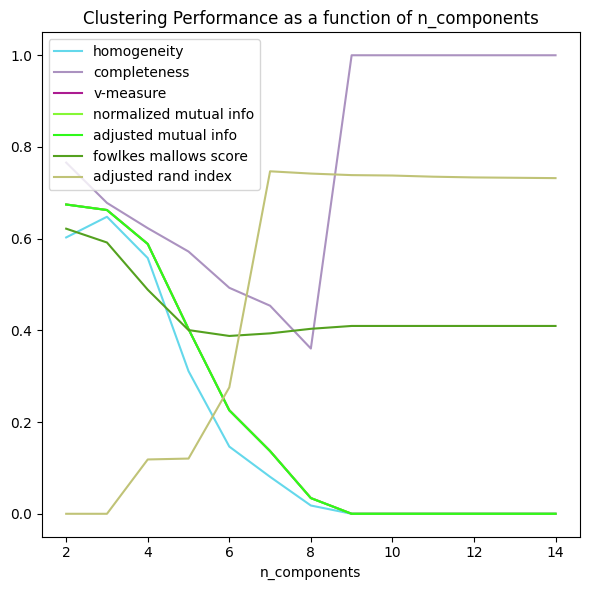

In [416]:
import random
r = lambda: random.randint(0,255)

scores = {
  'homogeneity' : homogeneity_scores,
  'completeness': completeness_scores,
  'v-measure': v_masure_scores,
  'normalized mutual info':nmi_scores,
  'adjusted mutual info':ami_scores,
  'fowlkes mallows score':fms_scores,
  'adjusted rand index':ari_scores
}

plt.figure(figsize=(6,6))
for ms in scores.keys():
  plt.plot(
    [i for i in range(2,15)],
    scores.get(ms),
    label=ms,
    c='#%02X%02X%02X' % (r(),r(),r())
  )
  
plt.xlabel("n_components")
plt.legend()
plt.title("Clustering Performance as a function of n_components")
plt.tight_layout()
plt.show()

In [ ]:
t2_pipe_dbscan["preprocessor"]["pca"].n_components = 5
t2_pipe_dbscan["clusterer"]["dbscan"].min_samples = 500
t2_pipe_dbscan.fit(test_two_x)

silhouette_coef = silhouette_score(t2_pipe_dbscan["preprocessor"].transform(test_two_x),t2_pipe_dbscan["clusterer"]["dbscan"].labels_)
ari = adjusted_rand_score(true_labels,t2_pipe_dbscan["clusterer"]["dbscan"].labels_)
nmi = normalized_mutual_info_score(true_labels, t2_pipe_dbscan["clusterer"]["dbscan"].labels_)
ami = adjusted_mutual_info_score(true_labels, t2_pipe_dbscan["clusterer"]["dbscan"].labels_)
homogeneity  = homogeneity_score(true_labels, t2_pipe_dbscan["clusterer"]["dbscan"].labels_)
completeness = completeness_score(true_labels, t2_pipe_dbscan["clusterer"]["dbscan"].labels_)
v_measure    = v_measure_score(true_labels, t2_pipe_dbscan["clusterer"]["dbscan"].labels_)
fms = fowlkes_mallows_score(true_labels, t2_pipe_dbscan["clusterer"]["dbscan"].labels_)

print("Silhouette Coeficient: {}".format(silhouette_coef))
print("Adjusted Rand Index: {}".format(ari))
print("Normal Mutual Information: {}".format(nmi))
print("Adjusted Mutual Information {}".format(ami))
print("Homogeneity: {}".format(homogeneity))
print("Completeness: {}".format(completeness))
print("V-Measure: {}".format(v_measure))
print("Fowlkes-Mallows Score: {}".format(fms))

Silhouette Coeficient: 0.39781260993372675
Adjusted Rand Index: 0.6988279416011123
Normal Mutual Information: 0.7913360308672188
Adjusted Mutual Information 0.7912309091487785
Homogeneity: 0.780625165981267
Completeness: 0.8023449097696449
V-Measure: 0.7913360308672189
Fowlkes-Mallows Score: 0.7529483473256495


Text(113.9222222222222, 0.5, 'Pred label')

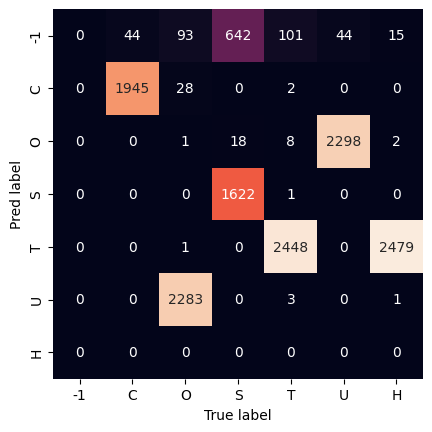

In [415]:
t2_pipe_dbscan["preprocessor"]["pca"].n_components = 7
t2_pipe_dbscan.fit(test_two_x)
mat = confusion_matrix(true_labels, t2_pipe_dbscan["clusterer"]["dbscan"].labels_)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=['-1']+test_two_letters,
            yticklabels=['-1']+test_two_letters)

plt.xlabel('True label')
plt.ylabel('Pred label')

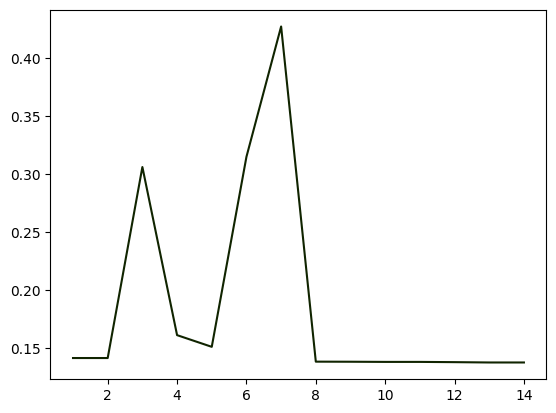

In [414]:
accuracy_scores_t2 = []

for i in range(1,15):
  t2_pipe_dbscan["clusterer"]["dbscan"].min_samples = 750
  t2_pipe_dbscan["preprocessor"]["pca"].n_components = i
  t2_pipe_dbscan.fit(test_two_x)
  accuracy_scores_t2.append(accuracy_score(true_labels, t2_pipe_dbscan["clusterer"]["dbscan"].labels_))
  
plt.plot(
  [i for i in range(1,15)],
  accuracy_scores_t2,
  label="Accuracy Score",
  c="#102400")

In [413]:
max_acc = dict()
for mn in range (750,761,1):
  t2_pipe_dbscan["clusterer"]["dbscan"].min_samples = mn
  accuracy_dbscan2= []

  for i in range(1,15):
    t2_pipe_dbscan["preprocessor"]["pca"].n_components = i
    t2_pipe_dbscan.fit(test_two_x)
    accuracy_dbscan2.append(accuracy_score(true_labels, t2_pipe_dbscan["clusterer"]["dbscan"].labels_))
  
  max_acc[str(mn)] = max(accuracy_dbscan2)

print(max_acc)

{'750': 0.4273030755025215, '751': 0.4272320477306627, '752': 0.4272320477306627, '753': 0.4272320477306627, '754': 0.42581149229348675, '755': 0.42581149229348675, '756': 0.42581149229348675, '757': 0.42566943674976915, '758': 0.42566943674976915, '759': 0.4253142978904752, '760': 0.4253142978904752}


In [407]:
print(max(max_acc.values()))

0.31479508487818736
